# Testing the Method on SANS-2D Data

## EMTK Object Oriented API Analysis

Loading ESS event mode toolkit (emtk)
Loading curves
Loading omega functions
Loading EventModeAnalyser


An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


EMAnalyser object created with 6073261 weighted events in range 0.010000018765608024 - 0.5941878658588073


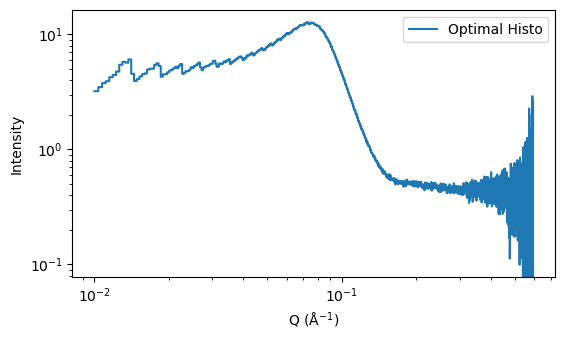

In [1]:
import numpy as np
import scipp as sc
import sciline
import scippneutron as scn
import plopp as pp
from ess import sans
from ess import isissans as isis
from ess.sans.types import *

from tqdm import tqdm


import matplotlib.pyplot as plt

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, this lets us change the source and force reload
# However, whilst the error reporting line number is right, the printout of
# the offending source is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def getWeightedSans2DEvents():
    """ Performs a super-lean version of the whole of the 
        above scipp data processing in one function.
    Returns:
        evs: numpy array of event Q values
        wts: numpy array of event weights
    """

    params = {}

    params[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.dat'
    params[Filename[SampleRun]] = 'SANS2D00063114.nxs'
    params[Filename[BackgroundRun]] = 'SANS2D00063159.nxs'
    params[Filename[EmptyBeamRun]] = 'SANS2D00063091.nxs'
    params[OutFilename] = 'reduced.nxs'

    params[NeXusMonitorName[Incident]] = 'monitor2'
    params[NeXusMonitorName[Transmission]] = 'monitor4'

    params[isis.SampleOffset] = sc.vector([0.0, 0.0, 0.053], unit='m')
    params[isis.MonitorOffset[Transmission]] = sc.vector([0.0, 0.0, -6.719], unit='m')

    params[WavelengthBins] = sc.linspace(
        'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
    )
    
    params[isis.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')
    
    mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
    params[WavelengthMask] = sc.DataArray(
        sc.array(dims=['wavelength'], values=[True]),
        coords={'wavelength': mask_interval},
    )
    
    params[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
    params[NonBackgroundWavelengthRange] = sc.array(
        dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
    )
    params[CorrectForGravity] = True
    params[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
    params[ReturnEvents] = True

    providers = (
        sans.providers + isis.providers + isis.data.providers + isis.sans2d.providers
    )
    providers = providers + (
        isis.data.transmission_from_background_run,
        isis.data.transmission_from_sample_run,
        sans.beam_center_from_center_of_mass,
    )

    pipeline = sciline.Pipeline(providers=providers, params=params)

    ### Old Code...
#    pipeline = sciline.Pipeline(
#    sans.providers + isis.sans2d.providers,
#    params=sans.sans2d.default_parameters,
#    )

#    pipeline[FileList[BackgroundRun]] = ['SANS2D00063159.hdf5']
#    pipeline.insert(sans.transmission_from_background_run)
#    pipeline[FileList[SampleRun]] = ['SANS2D00063114.hdf5']
#    pipeline.insert(sans.transmission_from_sample_run)
#    pipeline[FileList[EmptyBeamRun]] = ['SANS2D00063091.hdf5']
#    pipeline[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.hdf5'
#    pipeline[OutFilename] = 'reduced.nxs'
    
#    pipeline[WavelengthBins] = sc.linspace(
#        'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
#    )
    
#    pipeline[sans.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')
    
#    mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
#    pipeline[WavelengthMask] = sc.DataArray(
#        sc.array(dims=['wavelength'], values=[True]),
#        coords={'wavelength': mask_interval},
#    )
    
#    pipeline[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
#    pipeline[NonBackgroundWavelengthRange] = sc.array(
#        dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
#    )
#    pipeline[CorrectForGravity] = True
#    pipeline[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
#    pipeline[sans.ReturnEvents] = True
    ### End of old code...






    

    siq = pipeline.get(IofQ[SampleRun])
    sres= siq.compute()
    
    allsevents = sres.bins.concat().value


    seventQ = allsevents.coords['Q'].values
    seventW = allsevents.values
        
    nans = np.isnan(seventW)
    seventW[nans] = 0.0
    msk = np.where(seventW < 0.0)
    seventW[msk] = 0.0

    return seventQ, seventW







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def cauchy_cubed_integral(x1, x2, kappa):
    # Returns the integral of a cauchy-cubed distribution between two x values
    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    denom = 8.0 * np.pi**3.0 * kappa**2.0
    
    t1 = kappa * (3.0 * xmax**3.0 + 5.0 * xmax * kappa**2.0) / ( xmax**2.0 + kappa**2.0)**2.0
    t2 = kappa * (3.0 * xmin**3.0 + 5.0 * xmin * kappa**2.0) / (xmin**2.0 + kappa**2.0)**2.0
    t3 = 3.0 * np.arctan(xmax / kappa)
    t4 = 3.0 * np.arctan(xmin / kappa)

    result = (-t1 + t2 -t3 + t4)/denom
    
    
    return np.absolute(result)
    


def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    intg = norm.cdf(x1, loc=mu, scale=sigma) - norm.cdf(x2, loc=mu, scale=sigma)
    
    return np.absolute(intg)




evs, wts = getWeightedSans2DEvents()

ema1 = ema.EMAnalyser(evs, wts)

ema1.plot_histogram()
#ema1.plot_kde()

In [2]:
ema1.help()

The analyser object is created with a numpy array of events
(x-values) and their weights:


            import emtk.EventModeAnalyser.EMAnalyser as ema
            ema1 = ema.EMAnalyser(events, weights)

There are two provided workflows with the same API.  The first API
does regular histogram and least squares fit analysis with lmfit as a
backend.  So you need to define a function and parameters, exactly
according to lmfit documentation, which are passed through to lmfit.
These include:

            set_lse_function()
            make_lse_params()
            lse_fit()

And to get the results of those fits:
            plot_LSE_fit()
            get_lse_param_values()
            get_lse_param_errors()
            get_lse_param_names()

The last one takes the names as specified in the lmfit interface to
make the parameters, as passed to the function above.

The main event mode analysis part is a Markov-Chain Monte-Carlo
sampling method using emcee as a backend.  If you want to subsampl

Least squares model function defined.


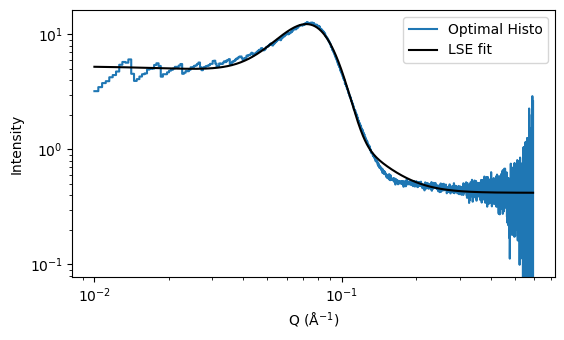

['amplitude', 'kappaSample', 'sigma', 'q0', 'kappaBG', 'm1', 'm2', 'm3']
[9.99260870e-01 1.22310839e-01 1.81068888e-02 7.33329300e-02
 7.59894147e-02 3.04083096e-01 1.82471083e-09 4.50437296e-01]
[3.77722162e-03 9.88833479e-03 1.70494396e-04 1.39505619e-04
 1.82204799e+07 9.17110234e-02 1.45589624e-01 8.62836278e-03]


In [4]:
def big_lse_pdf(x, amplitude, kappaSample, sigma, q0, kappaBG, m1, m2, m3):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3]))

    lor3 = mvals[0] * cauchy.pdf(x, scale=kappaSample, loc=0.0)**3.0 / cauchy_cubed_integral(ema1.xmin, ema1.xmax,kappaSample)
    lorbg= mvals[1] * cauchy.pdf(x, scale=kappaBG, loc=0.0)/cauchy_integral(ema1.xmin, ema1.xmax, kappaBG)
    gauss= mvals[2] * norm.pdf(x, scale=sigma, loc=q0) / gaussian_integral(ema1.xmin,ema1.xmax, q0, sigma)
    flt =  mvals[3] / uniform_integral(ema1.xmin, ema1.xmax)

    sol = amplitude *( lor3 + lorbg + gauss + flt)
    
    return sol


ema1.set_lse_function(big_lse_pdf)

ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    kappaSample=dict(value=0.05, min=0.001, max=1.0),\
    sigma=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),\
    kappaBG=dict(value=0.05, min=0.001, max=1.0),\
    m1=dict(value=0.1, min=0.0, max = 1.0),\
    m2=dict(value=0.1, min=0.0, max = 1.0),\
    m3=dict(value=0.1, min=0.0, max = 1.0)
)

ema1.lse_fit()
ema1.plot_LSE_fit()

pvals = ema1.get_lse_param_values()
psigs = ema1.get_lse_param_errors()
pnams = ema1.get_lse_param_names()

print(pnams)
print(pvals)
print(psigs)

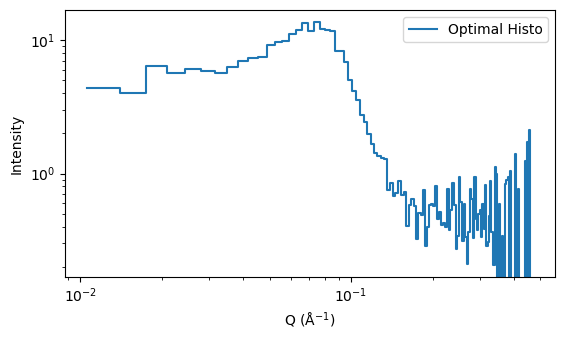

Calculating KDE
   - logarithmic scale conversion
nx 83
slice size 0.019674428227932764


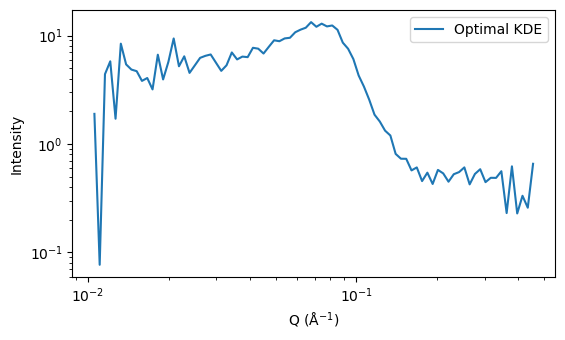

In [5]:
cpo = ema1.subsample(8000)
cpo.plot_histogram()
cpo.plot_kde()

In [6]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
        
    if 0.001 < kappaSample < 1.0 and\
    0.01 < sigma < 0.1 and\
    0.001 < q0 < 0.1 and\
    0.001 < kappaBG < 1.0 and\
    0.1 < m1 < 1.0 and\
    0.1 < m2 < 1.0 and\
    0.1 < m3 < 1.0 and\
    m1 + m2 + m3 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin

    
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    
    
    signal = cauchy.pdf(xx, loc=0.0, scale = kappaSample)**3.0
    background = cauchy.pdf(xx, loc=0.0, scale = kappaBG)
    gauss = norm.pdf(xx, loc=q0, scale = sigma)
    unif = uniform.pdf(xx, loc=xmin, scale = xmax)
    
    term1 = mvals[0] * signal / sig_int
    term2 = mvals[1] * background / bg_int
    term3 = mvals[2] * gauss / gauss_int
    term4 = mvals[3] * 1.0 / uniform_int
    
            
    if verbose:
        print("xmin:", self.xmin)
        print("xmax:", self.xmax)
        print("Signal:", signal)
        print("Background:", background)
        print("Gauss:", gauss)
        print("Gauss:", gauss)
        print("sig_int:", sig_int)
        print("bg_int:", bg_int)
        print("mvals:", mvals)
    
    result = (term1 + term2 + term3 + term4)**use_weights
    
    return result




def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    

    signal = mvals[0]*cauchy.pdf(data, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = mvals[1]*cauchy.pdf(data, loc=0.0, scale = kappaBG) / bg_int
    gauss = mvals[2]*norm.pdf(data, loc=q0, scale = sigma) / gauss_int
    unif = mvals[3] / uniform_int

    # Guard against zero values in each term
    minval = 1.0E-300

    msk = signal < minval
    signal[msk] = minval

    msk = background < minval
    background[msk] = minval

    msk = gauss < minval
    gauss[msk] = minval

    if unif < minval:
        unif = minval


    ll = np.log(signal)
    lbg = np.log(background)
    lgauss = np.log(gauss)
    lunif = np.log(unif)

    # logaddexp is used to add the two components in linear space
    # in theory I suppose you can do it before taking the log above...
    ll1 = np.logaddexp(ll, lbg)
    ll2 = np.logaddexp(ll1, lunif)
    ll3 = np.logaddexp(ll2, lgauss)
    ll4 = np.sum(ll3 * use_weights)
        
    result = lp + ll4
    
    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        if verbose:
            print("mvals", mvals)
            print("signal", signal)
            print("background", background)
            print("gauss", gauss)
            print("uniform", unif)
            print("sig_int", sig_int)
            print("bg_int", bg_int)
            print("gauss_int", gauss_int)
            print("uniform_int", uniform_int)
        
    return result


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
cpo.theta_seed = np.array([0.11610878745187037,\
                           0.018766787799024232,\
                           0.0719479371044884,\
                           0.999998495793329,\
                           0.275896153469968,\
                           0.3460716482480896,\
                           0.49294212343714894])

same_as_lse = np.array([0.05, 0.05, 0.07, 0.05, 0.1, 0.1, 0.1])


something_in_between =\
    np.array([0.08, 0.015, 0.07, 0.8, 0.35, 0.35, 0.35])

cpo.theta_seed = same_as_lse

# Seed MCMC search with LSE fit
cpo.lse_fit()
#cpo.theta_seed = cpo.get_lse_param_values()
#cpo.theta_seed = cpo.theta_seed[1:]




def exmax_fit(theta0, events, weights, niter=200, minimum_delta = 1E-06):
    # Test expectation maximisation 

    kappaSample, sigma, q0, kappaBG = theta0
    
    categories = np.zeros_like(events, dtype=np.integer)

    xmin = np.amin(events)
    xmax = np.amax(events)

    # Initial pass computing the maximum likelihood of the categories
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)
    
    signal = cauchy.pdf(events, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = cauchy.pdf(events, loc=0.0, scale = kappaBG) / bg_int
    gauss = norm.pdf(events, loc=q0, scale = sigma) / gauss_int
    unif = np.ones_like(events) / uniform_int

    # stack these event-by-event PDFs up into a grid
    catgrid = np.stack((signal, background))
    catgrid = np.vstack((catgrid, gauss))
    catgrid = np.vstack((catgrid, unif))

    # Find the maximum index as the intial maximum likelihood categorisation
    # on an event-by-event basis
    categories = np.argmax(catgrid, axis=0)

    # Note: in the main loop, each category will be computed point by point holding
    # everything else constant, so this code isn't duplicated below exactly.

    iteration = 0

    def log_prior(theta):
        # The main role of this function is to set 
        # parameter bounds of the bayesian search space
        kappaSample, sigma, q0, kappaBG = theta
        
        if 0.001 < kappaSample < 1.0 and\
        0.01 < sigma < 0.1 and\
        0.001 < q0 < 0.1 and\
        0.001 < kappaBG < 1.0:
            return 0.0
    
        return -np.inf


    def loglikelihood(theta, cat):

        kappaSample, sigma, q0, kappaBG = theta

        # set up category-dependent weighting parameters
        cat0 = cat == 0
        cat1 = cat == 1
        cat2 = cat == 2
        cat3 = cat == 3

        w0 = np.zeros_like(events)
        w1 = np.zeros_like(events)
        w2 = np.zeros_like(events)
        w3 = np.zeros_like(events)

        w0[cat0] = 1.0
        w1[cat1] = 1.0
        w2[cat2] = 1.0
        w3[cat3] = 1.0

        
        sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
        bg_int = cauchy_integral(xmin, xmax, kappaBG)
        gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
        uniform_int = uniform_integral(xmin, xmax)

        signal = w0 * cauchy.pdf(events, loc=0.0, scale = kappaSample)**3.0 / sig_int
        background = w1 * cauchy.pdf(events, loc=0.0, scale = kappaBG) / bg_int
        gauss = w2 * norm.pdf(events, loc=q0, scale = sigma) / gauss_int
        unif = w3 * np.ones_like(events) / uniform_int

        # Drop the zeros
        minval = 1.0E-300
        msk = signal < minval
        signal[msk] = minval

        msk = background < minval
        background[msk] = minval

        msk = gauss < minval
        gauss[msk] = minval

        msk = unif < minval
        unif[msk] = minval


        lsig = weights * np.log(signal)
        lbg = weights * np.log(background)
        lg = weights * np.log(gauss)
        lu = weights * np.log(unif)

        lp = 0.0 # log_prior(theta)

        if np.isnan(lp):
            print("ERROR: log prior is nan at", theta)
        if np.isinf(lp):
            print("ERROR: log prior is infinity at", theta)
        if np.isneginf(lp):
            print("ERROR: log prior is -infinity at", theta)

        ll = lp + lsig + lbg + lg + lu

        llsum = np.sum(ll)

        return(llsum)

        print(x0)


    
    
    def dloglikelihood(theta, cat):

        th0 = np.array(list(theta))
        dydp = np.zeros_like(th0)

        for ii in range(len(dydp)):
            p0 = th0[ii]
            if p0 == 0.0:
                p1 = 0.0001
                p2 = -0.0001
            else:
                p1 = p0 + p0/1000.0
                p2 = p0 - p0/1000.0

            dp1 = p1 - p0
            dp2 = p0 - p2

            parray1 = np.array(th0) # looks like python is a bit like ruby
            parray2 = np.array(th0) # you have to actually duplicate the objects
            parray1[ii] = p1
            parray2[ii] = p2

            yzero = loglikelihood(tuple(th0), cat)
            yone = loglikelihood(tuple(parray1), cat)
            ytwo = loglikelihood(tuple(parray2), cat)

            dy1 = yone-yzero
            dy2 = yzero-ytwo

            dy = 0.5*(dy1 + dy2)
            dp = 0.5*(dp1 + dp2) # probably it must always be that dp1 = dp2, but best be careful

            dydp[ii] = dy/dp

        return dydp


    def ddloglikelihood(theta, cat):

        th0 = np.array(list(theta))
        dydp = np.zeros_like(th0)

        for ii in range(len(dydp)):
            p0 = th0[ii]
            if p0 == 0.0:
                p1 = 0.0001
                p2 = -0.0001
            else:
                p1 = p0 + p0/1000.0
                p2 = p0 - p0/1000.0

            dp1 = p1 - p0
            dp2 = p0 - p2

            parray1 = np.array(th0) # looks like python is a bit like ruby
            parray2 = np.array(th0) # you have to actually duplicate the objects
            parray1[ii] = p1
            parray2[ii] = p2

            yzero = dloglikelihood(tuple(th0), cat)[ii]
            yone = dloglikelihood(tuple(parray1), cat)[ii]
            ytwo = dloglikelihood(tuple(parray2), cat)[ii]

            dy1 = yone-yzero
            dy2 = yzero-ytwo

            dy = 0.5*(dy1 + dy2)
            dp = 0.5*(dp1 + dp2) # probably it must always be that dp1 = dp2, but best be careful

            dydp[ii] = dy/dp

        return dydp

    iteration = 0
    oops = False
    
    while iteration < 50:

        # Newton iterate the parameters once in the direction to maximise the log-likelihood

        print("Maximum a-posteriori stage")

        theta = kappaSample, sigma, q0, kappaBG    
        outer_oldvals = np.array(theta)

        for ii in tqdm(range(0,20)):

            theta = kappaSample, sigma, q0, kappaBG    
            oldvals = np.array(theta)
        
            dy = dloglikelihood(theta, categories)
            ddy = ddloglikelihood(theta, categories)
            newvals = oldvals - dy / ddy
            loop_pchange = newvals - oldvals

            kappaSample, sigma, q0, kappaBG = tuple(newvals)

            if (np.absolute(loop_pchange) < 1.0E-06).all():
                break
        
        # Recompute the maximum likelihood categorisation event-by-event

        newcategories = np.array(categories)

        print("Maximum likelihood categorisation")        
        for ii in tqdm(range(len(events))): 
            # Event-by-event, maximise the likelihood of 
            # the category for that data point whilst
            # holding all other data points constant

            # Array to hold the likelihood result
            llcat = np.zeros(4)
            
            # Loop over all possible category values
            for jj in range(0, 4):
                # reset the entire category array
                testcat = np.copy(categories)
                # Change the value to current category in the loop
                testcat[ii] = jj
                # compute the likelihood and store it
                llcat[jj] = loglikelihood(theta, testcat)

            # Having evaluated each likelihood, the best category for
            # this data point is the one with the maximum value
            bestcat = np.argmax(llcat)

            # Overwrite the category array element with the best found category
            newcategories[ii] = bestcat

        # Update all category values for each data point with the new values
        categories = newcategories

        # Establish how much the parameters have changed overall for this iteration
        # If they have not changed within 1E-06 then terminate
        # Might want to make this a fractional thing at some point
        pchange = newvals - outer_oldvals

        print("Iteration", iteration)
        print("P :", newvals)
        print("DP:", pchange)

        iteration = iteration + 1

        if np.isinf(newvals).any()\
        or np.isneginf(newvals).any()\
        or np.isnan(newvals).any():
            oops = True

        if(np.absolute(pchange) < 1.0E-06).all() or oops:
            break

    if oops:
        print("WARNING: something went wrong, check the results.")
    else:
        print("Converged:")
        
    print(newvals)
    return newvals, categories


cpo.MCMC_fit(nburn=50, niter=20000)
#cpo.MCMC_fit(niter=10000, convergence="Gelman-Rubin")


                               

MCMC launch
Burn in:


  0%|                                                    | 0/50 [00:00<?, ?it/s]/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 49.76it/s]


Sampling:


100%|█████████████████████████████████████| 20000/20000 [06:25<00:00, 51.83it/s]

MCMC sampling complete.


Calculating KDE
   - logarithmic scale conversion
nx 83
slice size 0.019674428227932764


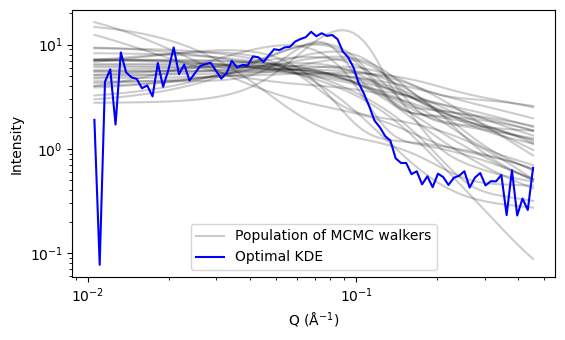

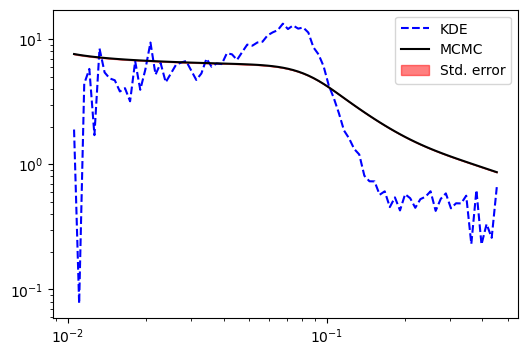

In [10]:
cpo.plot_MCMC_fit()

# Plot showing the average of the PDFs over all walkers

flt = cpo.sampler.get_chain(discard=20, thin=15, flat=True)
inds  = np.random.choice(len(flt), size=30, replace=False)
pt_sum = np.sum(cpo.kdey)

inds = np.arange(len(flt))

yfit = np.zeros((len(inds),cpo.kdex.size))

for ind in inds:
    smp = flt[ind]
    yfit[ind] = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)

ymean = np.mean(yfit, axis=0)
ystd = np.std(yfit, axis=0)
ystd = ystd / np.sqrt(len(inds))

                
ysum = np.sum(ymean)
scale = pt_sum / ysum
ymean = ymean * scale
ystd = ystd * scale

fig,ax=plt.subplots()

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.plot(cpo.kdex, ymean, color='black', label='MCMC')
plt.fill_between(cpo.kdex, ymean-ystd, ymean+ystd, color='red', alpha=0.5, label='Std. error')
#plt.xlabel('$\Delta$E (meV)')
#plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
fig.set_size_inches(6,4)
#plt.savefig('fit_mean.png', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
shortTheta = np.array([0.08, 0.015, 0.07, 0.07])

pars, cats = exmax_fit(shortTheta, cpo.data, cpo.weights)

Maximum a-posteriori stage


 30%|█████████████▏                              | 6/20 [00:00<00:01,  7.48it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:21<00:00, 364.82it/s]


Iteration 0
P : [0.05824169 0.01298093 0.0735873  0.13270194]
DP: [-0.02175831 -0.00201907  0.0035873   0.06270194]
Maximum a-posteriori stage


 15%|██████▌                                     | 3/20 [00:00<00:02,  6.87it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 356.30it/s]


Iteration 1
P : [0.0611996  0.01253948 0.07432834 0.14703161]
DP: [ 0.00295792 -0.00044145  0.00074104  0.01432967]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.15it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 360.23it/s]


Iteration 2
P : [0.06288559 0.01232727 0.07477447 0.14957683]
DP: [ 0.00168599 -0.00021221  0.00044613  0.00254522]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.29it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:21<00:00, 364.57it/s]


Iteration 3
P : [0.06395514 0.01220997 0.07506779 0.15023293]
DP: [ 0.00106954 -0.00011731  0.00029332  0.0006561 ]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.20it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [01:00<00:00, 133.02it/s]


Iteration 4
P : [0.06460646 0.01213788 0.07524776 0.15045505]
DP: [ 6.51321175e-04 -7.20855486e-05  1.79966932e-04  2.22123685e-04]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.19it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 361.10it/s]


Iteration 5
P : [0.0651861  0.01207984 0.07541569 0.15071622]
DP: [ 5.79641239e-04 -5.80363074e-05  1.67936434e-04  2.61171118e-04]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.06it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 360.82it/s]


Iteration 6
P : [0.06571558 0.01202811 0.07557316 0.15097997]
DP: [ 5.29481697e-04 -5.17334440e-05  1.57467101e-04  2.63750019e-04]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.09it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 360.50it/s]


Iteration 7
P : [0.06628189 0.01197637 0.0757504  0.15132279]
DP: [ 5.66304745e-04 -5.17396548e-05  1.77236445e-04  3.42820555e-04]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.19it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 352.71it/s]


Iteration 8
P : [0.06664974 0.01196735 0.07589705 0.15193108]
DP: [ 3.67853121e-04 -9.02010288e-06  1.46652143e-04  6.08287573e-04]
Maximum a-posteriori stage


 10%|████▍                                       | 2/20 [00:00<00:02,  6.02it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 354.97it/s]


Iteration 9
P : [0.06692936 0.0119505  0.07599658 0.15220616]
DP: [ 2.79621332e-04 -1.68533578e-05  9.95271306e-05  2.75077751e-04]
Maximum a-posteriori stage


  5%|██▏                                         | 1/20 [00:00<00:04,  4.51it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 356.00it/s]


Iteration 10
P : [0.0670581  0.01194551 0.07604586 0.15236447]
DP: [ 1.28738261e-04 -4.99177715e-06  4.92844435e-05  1.58311194e-04]
Maximum a-posteriori stage


  5%|██▏                                         | 1/20 [00:00<00:04,  4.64it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 348.47it/s]


Iteration 11
P : [0.06718676 0.01194415 0.07609949 0.15256349]
DP: [ 1.28667100e-04 -1.35512805e-06  5.36286812e-05  1.99019369e-04]
Maximum a-posteriori stage


  5%|██▏                                         | 1/20 [00:00<00:04,  4.36it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 358.79it/s]


Iteration 12
P : [0.06727239 0.0119351  0.07612505 0.15260347]
DP: [ 8.56273657e-05 -9.05038814e-06  2.55598615e-05  3.99770552e-05]
Maximum a-posteriori stage


  5%|██▏                                         | 1/20 [00:00<00:04,  4.63it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 360.16it/s]


Iteration 13
P : [0.06735791 0.01192256 0.07614624 0.15260347]
DP: [ 8.55154629e-05 -1.25417987e-05  2.11857362e-05  8.90185564e-10]
Maximum a-posteriori stage


  5%|██▏                                         | 1/20 [00:00<00:04,  4.53it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 357.87it/s]


Iteration 14
P : [0.06737927 0.01191942 0.07615153 0.15260346]
DP: [ 2.13573159e-05 -3.13639388e-06  5.29688836e-06 -1.33528033e-09]
Maximum a-posteriori stage


  0%|                                                    | 0/20 [00:00<?, ?it/s]


Maximum likelihood categorisation


100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 354.65it/s]

Iteration 15
P : [0.06737927 0.01191942 0.07615153 0.15260347]
DP: [-3.18879645e-11 -2.44780758e-12  0.00000000e+00  4.45092796e-10]
Converged:
[0.06737927 0.01191942 0.07615153 0.15260347]


In [20]:
def pmf(xx, theta, cat, weights):
    kappaSample, sigma, q0, kappaBG = theta

    xmin = np.amin(xx)
    xmax = np.amax(xx)

    print(cat)

    cat0 = cat == 0
    cat1 = cat == 1
    cat2 = cat == 2
    cat3 = cat == 3

    print(cat0)
    print(cat1)
    print(cat2)
    print(cat3)

    w0 = np.zeros_like(cat)
    w1 = np.zeros_like(cat)
    w2 = np.zeros_like(cat)
    w3 = np.zeros_like(cat)

    w0[cat0] = 1.0
    w1[cat1] = 1.0
    w2[cat2] = 1.0
    w3[cat3] = 1.0

    w0 = np.sum(w0 * weights)
    w1 = np.sum(w1 * weights)
    w2 = np.sum(w2 * weights)
    w3 = np.sum(w3 * weights)

    print("Npts", len(weights))
    print("Weight sum", np.sum(weights))

    print("Term weights:", w0, w1, w2, w3)

    print("Term weight sum:", w0 + w1 + w2 + w3)

    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    signal = w0 * cauchy.pdf(xx, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = w1 * cauchy.pdf(xx, loc=0.0, scale = kappaBG) / bg_int
    gauss = w2 * norm.pdf(xx, loc=q0, scale = sigma) / gauss_int
    unif = w3 * np.ones_like(xx) / uniform_int

    result = signal + background + gauss + unif

    return(result)


[2 2 2 ... 2 2 2]
[False False False ... False False False]
[False False False ... False False False]
[ True  True  True ...  True  True  True]
[False False False ... False False False]
Npts 8000
Weight sum 4.5501785
Term weights: 1.2693939461023547 0.47793588042259216 2.2143682470195927 0.5884801822248846
Term weight sum: 4.550178255769424


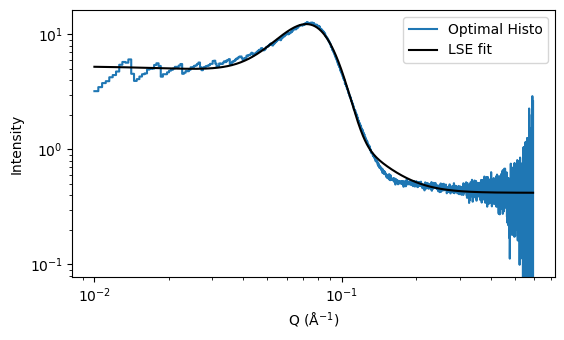

Calculating KDE
   - logarithmic scale conversion


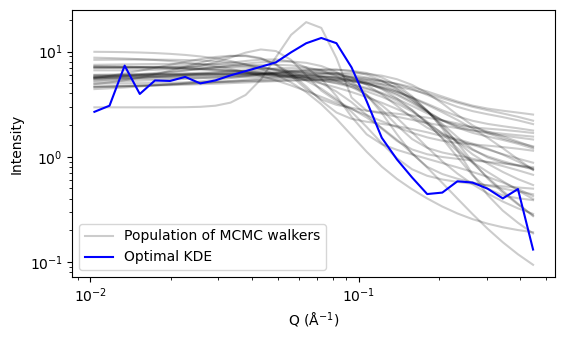

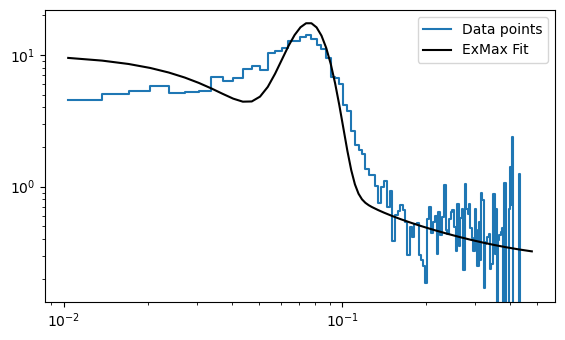

Unique: [0 1 2 3]


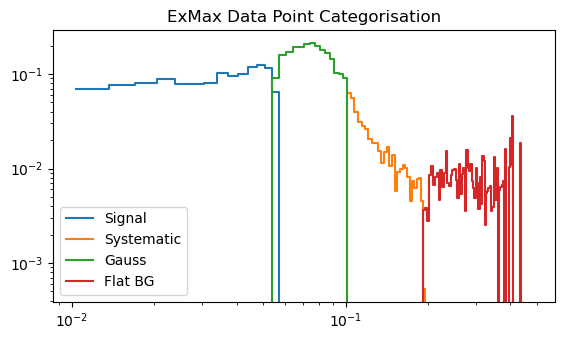

In [23]:
def optimal_n_bins(data) -> int:
    # Protect against calling when there are no data points
    if data is None:
        raise ValueError(
            f"attempt to find optimal number of data points with no data defined."
            )

    n_events = len(data)
    xmin = np.amin(data)
    xmax = np.amax(data)

    # Apply the Freedman-Diaconis calculation
    # First calculate the interquartile range of the data
    iqr = np.subtract(*np.percentile(data, [75, 25]))

    # If all the data points are equal (or maybe there is only one data point)
     # then the IQR is zero and that makes no sense for anything that comes after
    if iqr == 0.0:
        print("WARNING: interquartile range is zero.")
        return 0

    # If we get to this point it's probably OK, return the Freedman-Diaconis value
    return int((xmax - xmin)*n_events**(1.0/3.0)/(2.0*iqr))


def category_histos(data, weights, cats):
    cat_vals = np.unique(cats)
    print("Unique:", cat_vals)

    catname=["Signal", "Systematic", "Gauss", "Flat BG"]

    pmax = np.amax(data)
    pmin = np.amin(data)
    opt_n_bin = optimal_n_bins(data)
    slic = (pmax - pmin)/(opt_n_bin+1)
    hbins = np.arange(pmin, pmax, slic)

    for cat in np.nditer(cat_vals):
        msk = cats == cat
        pts = data[msk]
        wts = weights[msk]
        

        hst = np.histogram(pts, bins=hbins, density=False, weights=wts)
        xh = hst[1]
        xh = xh[:-1]
        yh = hst[0]

        plt.step(xh, yh, where='post', label=catname[cat])
    plt.legend()
    plt.title('ExMax Data Point Categorisation')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
        


solution_theta = tuple(pars)

yfit = pmf(cpo.histx, solution_theta, cats, cpo.weights)

ysum = np.sum(yfit)
dsum = np.sum(cpo.histy)
scale = dsum / ysum

ema1.plot_LSE_fit()
cpo.plot_MCMC_fit()

plt.step(cpo.histx, cpo.histy, where='post', label='Data points')
plt.plot(cpo.histx, scale * yfit, color='black', label='ExMax Fit')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

category_histos(cpo.data, cpo.weights, cats)



With the category plot you can see it's *kind of* working properly, but that's the source of the "bad" fit.  There is a sharp cut-off between the categories, which makes the gaussian sigma small in the MAP fitting part and likewise for the cauchy sample term.  I would have expected / hoped for some kind of smooth transition with a bit of mixing at the boundaries.  If we find the method to do that then this will work.

In [24]:
import pandas

pn = cpo.get_lse_param_names()
pn = pn[1:5]

df = pandas.DataFrame({"PARAMETER": pn, "LSE": cpo.get_lse_param_values()[1:5], "ExMax": pars})
print(df)

     PARAMETER       LSE     ExMax
0  kappaSample  0.116757  0.067379
1        sigma  0.017849  0.011919
2           q0  0.072160  0.076152
3      kappaBG  1.000000  0.152603


(20000, 32, 7)
(500, 32, 7)


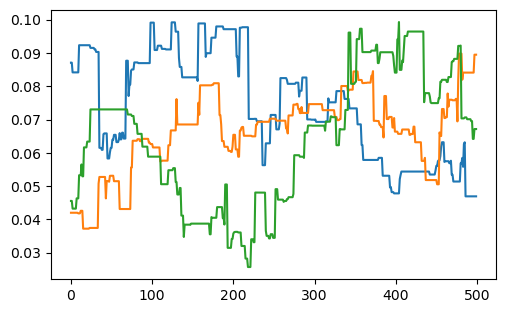

In [25]:
chz = cpo.sampler.get_chain()
nwk = cpo.nwalkers
ndm = cpo.ndim

rlen = chz.shape[0]

print(chz.shape)

burned = chz[-500::]
#=np.delete(chz, np.s_[rlen-42:rlen], axis=0)
print(burned.shape)
ch1 = burned[:,1,2]
ch2 = burned[:,2,2]
ch3 = burned[:,3,2]
fig,ax=plt.subplots()
ax.plot(ch1)
ax.plot(ch2)
ax.plot(ch3)

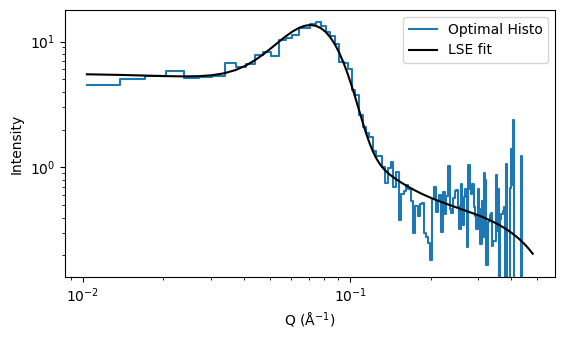

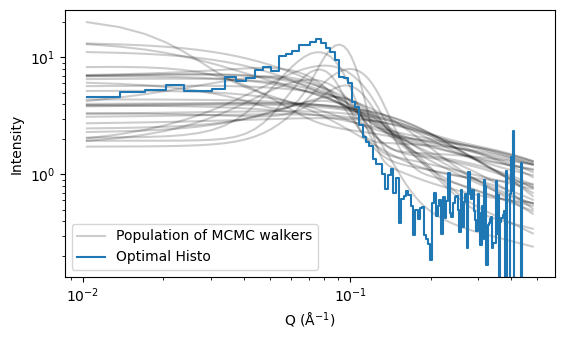

Calculating KDE
   - logarithmic scale conversion


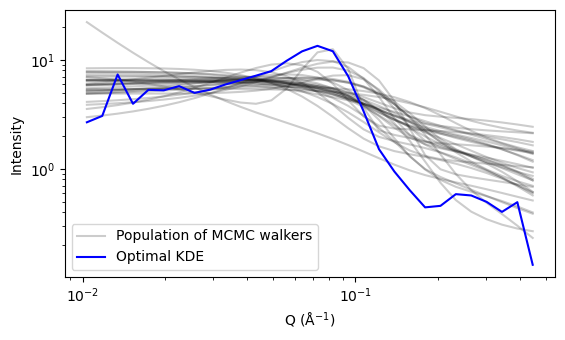

In [26]:
cpo.plot_LSE_fit()
cpo.plot_MCMC_fit(method="histo")
cpo.plot_MCMC_fit(method="kde")


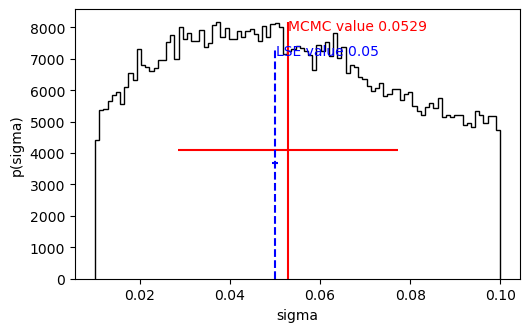

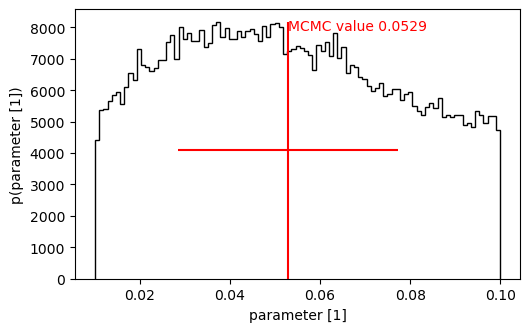

In [27]:
lookat=1
cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False)

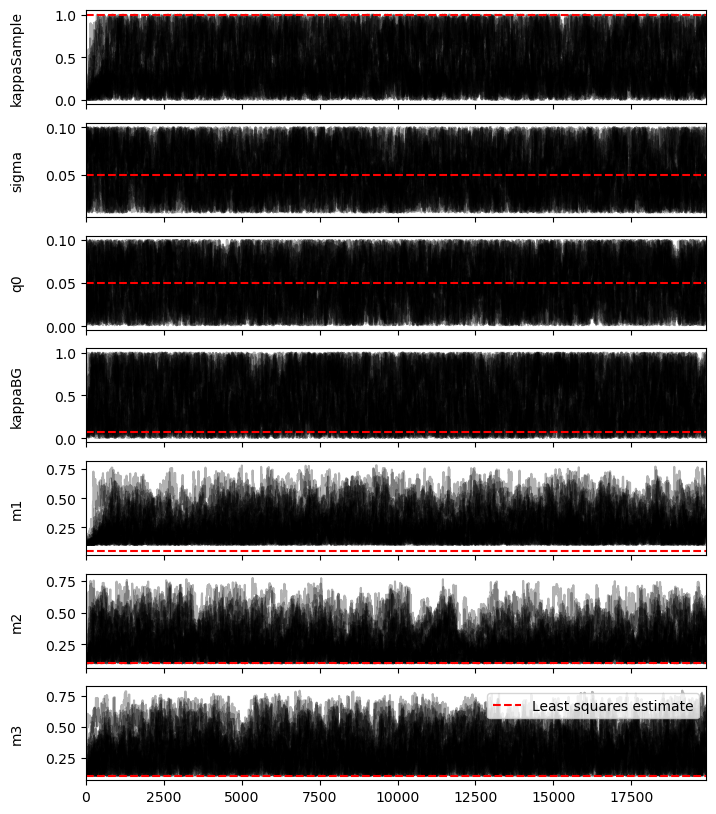

In [28]:
cpo.plot_MCMC_convergences()

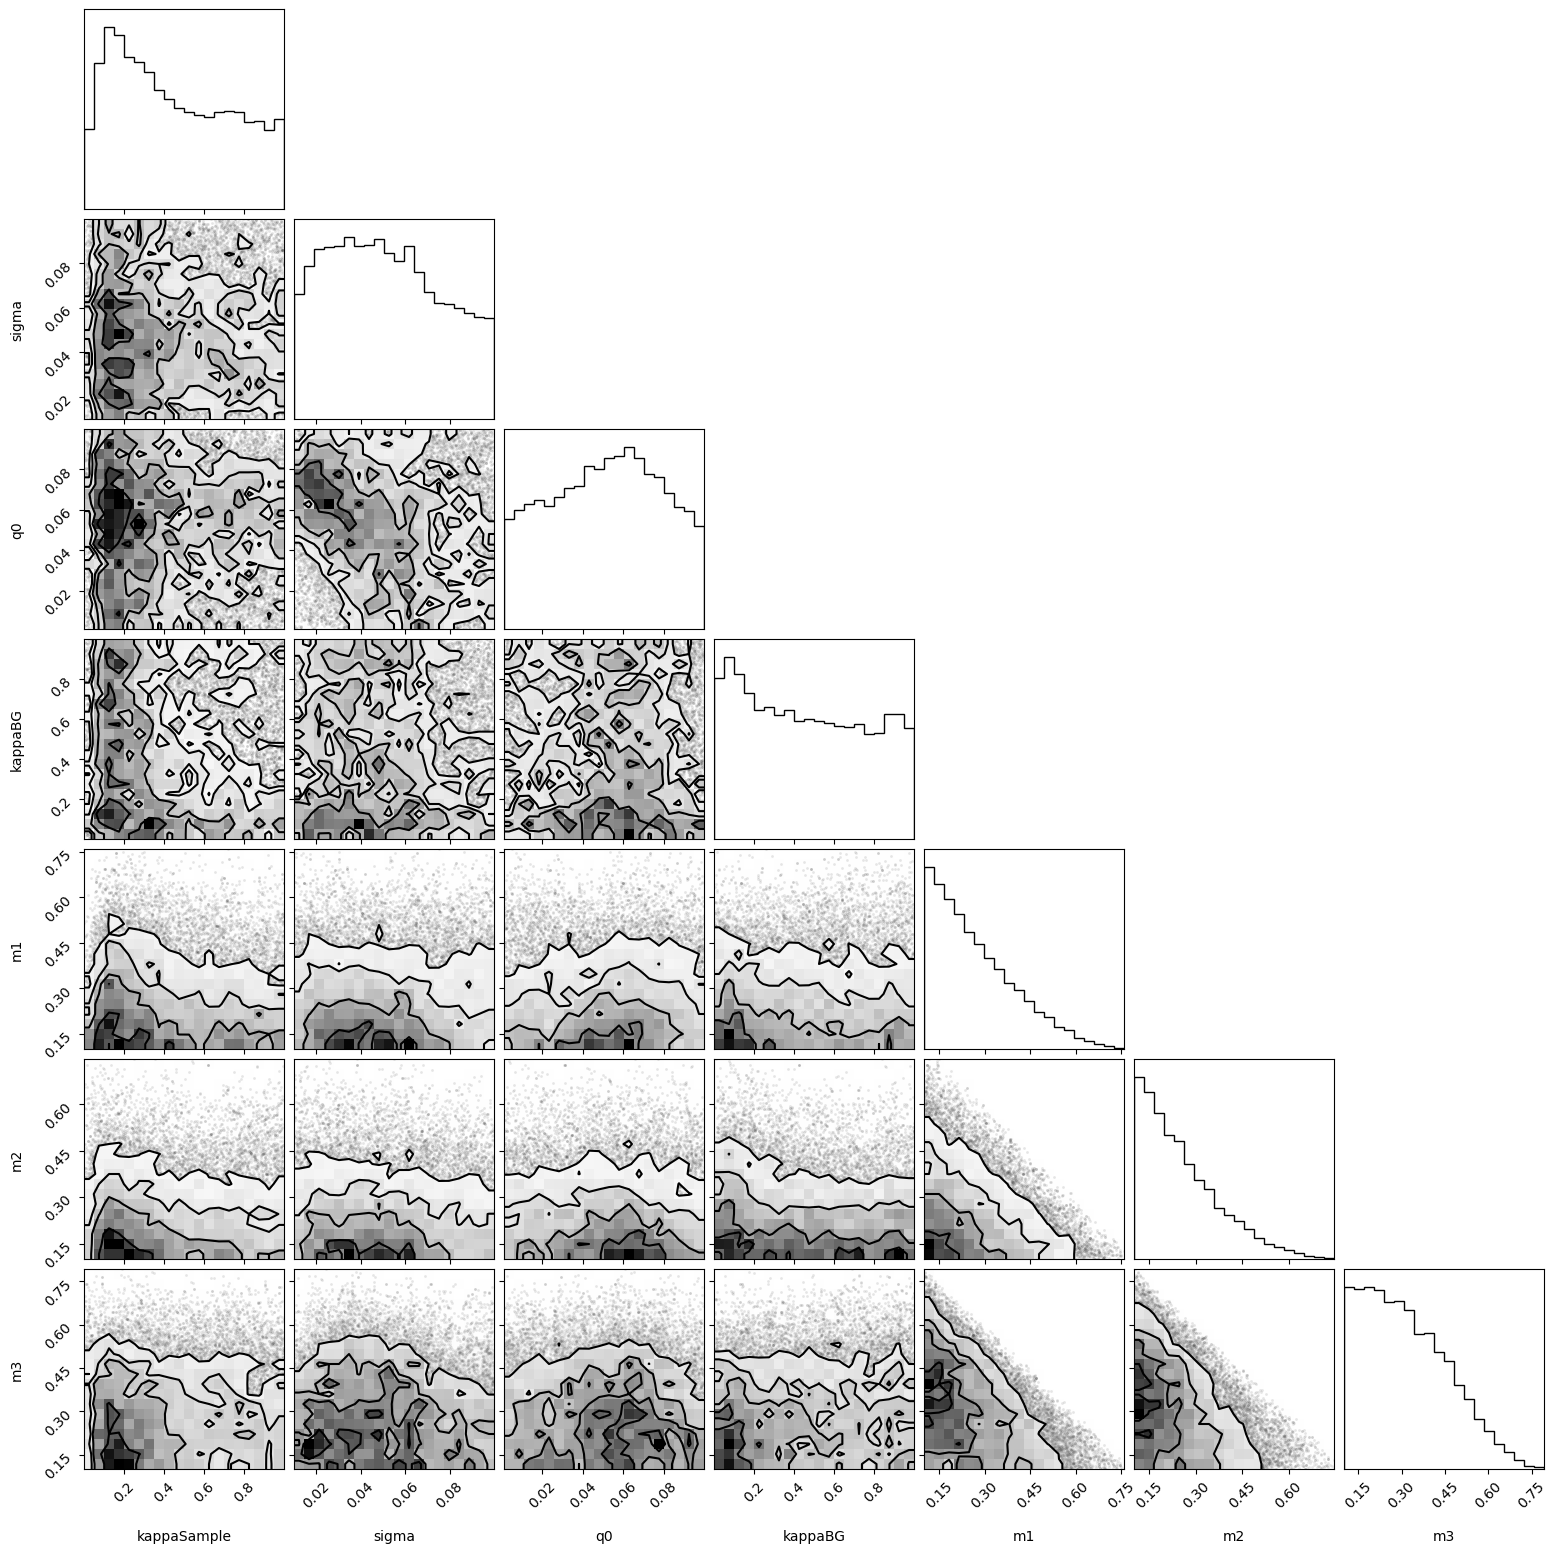

In [31]:
import corner
labs = cpo.get_lse_param_names()
labs.pop(0)

fff = corner.corner(
    cpo.sampler.get_chain(discard=10000, thin=15, flat=True), labels=labs)

In [29]:
pvals, psigs = cpo.get_MCMC_parameters()
pnams = cpo.get_lse_param_names()

for i in range(0, pvals.size):
    print(pnams[i], pvals[i], psigs[i])

amplitude 0.4358187670616067 0.0003545834239455668
kappaSample 0.0528851547485228 3.062966587428109e-05
sigma 0.05052203419211637 3.36835494586548e-05
q0 0.45680684679093636 0.000368288128481795
kappaBG 0.26635116999573444 0.00016739431292497195
m1 0.2617136068172134 0.000160337693866366
m2 0.3109050425557832 0.00018116082834965263
